<a href="https://colab.research.google.com/github/sarvesh237/lfkdsahkhfa/blob/master/NewsRecommenderAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#for lemmatization
import nltk
nltk.download("wordnet")
nltk.download('stopwords')
#to remove stop words
from nltk.corpus import stopwords

#for tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

#cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

#gaussian mixture
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import TruncatedSVD# TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Importing the collected data**

In [2]:
df_1 = pd.read_csv("https://github.com/sarvesh237/NewsRecommenderIDC401/raw/master/agrima_news_data.csv")
df_2 = pd.read_csv("https://github.com/sarvesh237/NewsRecommenderIDC401/raw/master/sarvesh_news_data.csv")
df_3 = pd.read_csv("https://github.com/sarvesh237/NewsRecommenderIDC401/raw/master/satender_news_data.csv")
df_4 = pd.read_csv("https://github.com/sarvesh237/NewsRecommenderIDC401/raw/master/vishal_news_data.csv")

# **Preprocessing the csv files.**

In [3]:
del df_1['Unnamed: 0']
del df_2['index']
del df_2['Unnamed: 0']
df_2.rename(columns = {'content':'Content'}, inplace = True)
del df_3['Unnamed: 0']
del df_3['Title']
del df_4['Unnamed: 0']

**Remove capitalization, numbers, stop words, non-english characters, drop empty rows and duplicates.**

In [4]:
news_corpus = pd.concat([df_1,df_2,df_3,df_4],ignore_index=True)
news_corpus = news_corpus.dropna() #dropping NaN
news_corpus = news_corpus[news_corpus.Content != ''] #dropping empty rows
news_corpus = news_corpus.drop_duplicates()
news_corpus["Content"] = news_corpus['Content'].str.replace('[^\w\s]',' ')
news_corpus = news_corpus[news_corpus['Content'].map(lambda x: x.isascii())] #remove non-english #find a better way
news_corpus['Content'] = news_corpus['Content'].str.lower() #convert to lowercase
news_corpus.replace('\d+', '', regex=True, inplace=True) #remove numbers

stop_words = stopwords.words('english')
stop_words.extend(['span','class','spacing','href','html','http','title','said','that'])
news_corpus['Content'] = news_corpus['Content'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
news_corpus = news_corpus.apply(lambda x: [item for item in x if item not in stop_words])


**Lemmatization**

In [5]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

news_corpus['Content'] = news_corpus.Content.apply(lemmatize_text)
news_corpus['Content'] = news_corpus['Content'].apply(', '.join) #convert list of words to a sentence
news_corpus.replace(',', '', regex=True, inplace=True) # remove commas
news_corpus = news_corpus.reset_index(drop=True)
news_corpus


,Content
0,medium report about swedish manufacturer scani...
1,access covid vaccine cooperation technology cl...
2,after severe criticism over holding consultati...
3,former congress president rahul gandhi thursda...
4,enforcement directorate attached three immovab...
...,...
4589,over mughal gold coin dating back early centur...
4590,china planning spend tibet five year plan allo...
4591,supreme court tuesday came with solution stale...
4592,indian american maju varghese previously serve...


# TF-IDF

In [6]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(news_corpus.Content)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
#denselist = dense.tolist() #very expensive
df_vecs = pd.DataFrame(dense, columns=feature_names)
df_vecs

,aabad,aadarsh,aadat,aadhaar,aadhar,aadhi,aadmi,aage,aajtak,aakash,aaksha,aamir,aamk,aandolan,aandolanjivi,aane,aapada,aapko,aapsu,aaravv,aarogya,aarohan,aarti,aasha,aashay,aashirwad,aasiya,aastha,aasu,aate,aatma,aatmanidbhar,aatmanirbhar,aatmanirbharbharat,aatmanirbharta,aatmiyata,aatmnirbhar,aatmnirbharta,aawam,aaya,...,zhao,zhoigar,zhuoran,ziarul,zila,zilla,zillion,zimbabwe,zindabad,zindagi,zindagii,zinta,ziyad,zojila,zolgensma,zomato,zombie,zonal,zone,zongqi,zoo,zoological,zoology,zoom,zoonotic,zoramthanga,zothankhuma,zoya,zptcs,ztdrktlic,zuali,zubair,zubin,zurbuchen,zurich,zuxxmlt,zwift,zyada,zycov,zydus
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **LSA : Latent Semantic Analysis**

In [7]:
sv_dec = TruncatedSVD(n_components = 50)  # components(no. of latent factors) < n ; n : no. of docs.
ls_analysis = sv_dec.fit_transform(vectors.T)

sv_dec.singular_values_ # eigenvalues for svd (in decreasing order)

array([13.49665211,  8.19753288,  6.65195647,  6.45052751,  6.13464353,
        5.38660289,  5.15440844,  4.58017211,  4.3733524 ,  4.27803598,
        4.22046108,  4.12363358,  4.06321418,  4.03831253,  3.93009516,
        3.91258603,  3.78111581,  3.73164427,  3.67963898,  3.61936482,
        3.56683814,  3.4814034 ,  3.40720819,  3.36241177,  3.31190976,
        3.29703183,  3.26998236,  3.2228747 ,  3.14692757,  3.13960672,
        3.10124631,  3.06519207,  3.01134691,  2.97251839,  2.94794855,
        2.9401983 ,  2.91708122,  2.86351923,  2.85597115,  2.78059404,
        2.7709898 ,  2.74950216,  2.73775372,  2.72112672,  2.69751674,
        2.69082222,  2.67515906,  2.64088661,  2.62294277,  2.61027266])

In [8]:
variance =  sv_dec.singular_values_/sum(sv_dec.singular_values_) # checking the variance captured by eigenvalues
variance

array([0.06979244, 0.0423902 , 0.03439788, 0.03335627, 0.03172281,
       0.02785462, 0.02665392, 0.02368449, 0.02261501, 0.02212212,
       0.02182439, 0.02132369, 0.02101126, 0.02088249, 0.02032289,
       0.02023234, 0.0195525 , 0.01929668, 0.01902775, 0.01871607,
       0.01844445, 0.01800266, 0.01761899, 0.01738734, 0.01712619,
       0.01704926, 0.01690938, 0.01666578, 0.01627305, 0.0162352 ,
       0.01603683, 0.01585039, 0.01557195, 0.01537117, 0.01524411,
       0.01520404, 0.0150845 , 0.01480752, 0.01476849, 0.01437871,
       0.01432904, 0.01421793, 0.01415718, 0.0140712 , 0.01394911,
       0.01391449, 0.01383349, 0.01365627, 0.01356348, 0.01349796])

In [9]:
sv_dec = TruncatedSVD(n_components = 25) # components with accepted variance
las = sv_dec.fit_transform(vectors)

#print(las,las.shape)

Topic - Document matrix

In [10]:
# Representation of each doc in terms of latent topics after dimensionality reduction
col = []
for i in range(las.shape[1]):
    col.append("topic_{}".format(i)) 

topic_df = pd.DataFrame(las, columns = col)

topic_df["Docs"] = news_corpus.Content

l = ["Docs"]
for i in col:
    l.append(i)

display(topic_df[l])


,Docs,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,medium report about swedish manufacturer scani...,0.129416,-0.031665,-0.002052,0.016612,-0.058607,-0.036353,-0.018085,0.009862,0.001978,-0.019945,0.011459,0.013774,0.008962,-0.052583,0.009541,-0.013395,0.062546,-0.036113,-0.007925,0.029087,0.020511,0.006355,-0.020090,-0.047076,-0.055364
1,access covid vaccine cooperation technology cl...,0.241852,-0.033734,0.076382,0.116272,-0.062967,-0.107494,-0.079228,-0.059930,-0.054079,-0.138059,-0.001696,-0.101836,0.026005,0.044775,-0.100064,0.013326,0.117427,0.019423,0.024208,-0.022674,0.003841,-0.028962,-0.056778,0.099070,0.005820
2,after severe criticism over holding consultati...,0.187095,-0.047154,-0.003872,0.027540,-0.070213,-0.018198,-0.070558,-0.018470,-0.001954,-0.019098,-0.011103,-0.018873,0.019769,-0.005051,0.036796,-0.074390,0.032067,-0.070089,-0.016627,-0.006851,0.071052,0.004856,-0.091585,-0.125529,-0.107162
3,former congress president rahul gandhi thursda...,0.177060,-0.026036,0.029292,0.010224,-0.039879,-0.040948,-0.059010,0.027710,-0.033104,-0.083175,0.102425,-0.065097,-0.007441,-0.009155,0.024386,0.014198,0.056764,-0.039802,-0.001902,0.025890,0.029875,0.002316,-0.003660,-0.036197,-0.005198
4,enforcement directorate attached three immovab...,0.134256,-0.048095,-0.066809,-0.030217,-0.111699,0.012932,0.045190,0.013406,0.053497,-0.025637,-0.005280,0.024902,-0.035699,-0.090034,0.038510,-0.006537,0.097767,-0.025477,-0.034105,0.037466,-0.054450,-0.021983,0.011508,-0.075111,-0.110973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4589,over mughal gold coin dating back early centur...,0.086212,-0.022274,-0.033228,-0.015105,-0.062892,-0.042075,0.091939,0.036266,0.021039,-0.009830,0.004807,0.001759,-0.011984,-0.039376,0.006517,-0.037640,0.003978,-0.014586,0.018348,-0.009713,0.018848,0.000979,-0.006577,0.006240,-0.020307
4590,china planning spend tibet five year plan allo...,0.123348,-0.013562,0.004554,0.000897,-0.026681,-0.072699,-0.033837,-0.033709,-0.019148,-0.022399,-0.066320,-0.000206,0.025473,-0.016905,-0.009882,-0.008277,0.039070,-0.002640,-0.013030,0.005778,0.029818,-0.022677,0.016341,0.020162,0.024956
4591,supreme court tuesday came with solution stale...,0.178528,-0.066110,-0.074739,-0.003261,-0.120695,0.127874,-0.102586,-0.017727,0.032728,-0.019333,-0.024173,0.009606,0.003779,-0.012430,0.027360,0.007845,0.021745,0.009865,0.019025,-0.005260,0.044307,0.015551,0.035241,-0.014285,-0.030690
4592,indian american maju varghese previously serve...,0.080712,-0.038111,0.006447,0.013000,-0.024410,-0.039602,-0.025027,0.020795,0.020091,-0.049970,-0.054819,-0.039953,-0.012609,0.058166,-0.029990,-0.055408,0.038859,0.004535,0.036122,0.038169,0.019080,-0.010314,0.000506,0.080673,-0.038132


**Visualizing the topics**

In [11]:
'''import umap
import matplotlib.pyplot as plt

embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(las)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], c = range(4594),s=15 )
plt.show()'''

'import umap\nimport matplotlib.pyplot as plt\n\nembedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(las)\n\nplt.figure(figsize=(7,5))\nplt.scatter(embedding[:, 0], embedding[:, 1], c = range(4594),s=15 )\nplt.show()'

**Topics and terms list**

In [12]:
Sigma = sv_dec.singular_values_ 
V_transpose = sv_dec.components_.T
terms = vectorizer.get_feature_names()

for index, component in enumerate(sv_dec.components_):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)
del Sigma,V_transpose,terms,zipped,top_terms_key

Topic 0:  ['said', 'that', 'covid', 'case', 'will', 'farmer', 'have', 'state', 'with', 'minister']
Topic 1:  ['covid', 'vaccine', 'case', 'death', 'vaccination', 'health', 'total', 'reported', 'dose', 'active']
Topic 2:  ['election', 'assembly', 'party', 'vaccine', 'congress', 'seat', 'will', 'poll', 'minister', 'bengal']
Topic 3:  ['vaccine', 'vaccination', 'farmer', 'dose', 'first', 'covid', 'modi', 'dos', 'law', 'covaxin']
Topic 4:  ['farmer', 'law', 'farm', 'protest', 'congress', 'price', 'protesting', 'death', 'party', 'hour']
Topic 5:  ['court', 'vaccine', 'justice', 'supreme', 'vaccination', 'election', 'dose', 'petition', 'bench', 'hearing']
Topic 6:  ['police', 'vaccine', 'arrested', 'dose', 'farmer', 'vaccination', 'accused', 'bengal', 'west', 'delhi']
Topic 7:  ['sabha', 'price', 'congress', 'rajya', 'budget', 'house', 'party', 'opposition', 'session', 'parliament']
Topic 8:  ['lakh', 'price', 'sabha', 'from', 'fuel', 'rajya', 'budget', 'crore', 'petrol', 'bengal']
Topic 9: 

# **LDA : Latent Dirichlet Allocation**

In [13]:
#lda

lda = LatentDirichletAllocation(n_components=25)
lda_matrix = lda.fit_transform(df_vecs)
lda_topics = lda.fit(df_vecs)
for idx, topic in enumerate(lda.components_):
        print ("Topic ", idx, " ".join(feature_names[i] for i in topic.argsort()[:-10 - 1:-1]))

Topic  0 palghar maninderjit khempreet syria clashed juvenile fcra bahl adoption paswan
Topic  1 gita ayodhya ansari temple harry meghan royal prince interview mehta
Topic  2 toy edhi kappan tihar stick gelatin alwar finally amravati sahni
Topic  3 morbid swami bhagavad adarsh stabbed bhatia resisting snatcher tonight robbery
Topic  4 mallya goswami balakot sewage symptom genome noida tejas mous extradition
Topic  5 shiva maha shivratri lord rathod timing uproar ruckus chavan adjourned
Topic  6 itbp chamba gorge illegitimate emhoff donkey sanjeevani newsprint caput malkangiri
Topic  7 kumbh playerscript mela haridwar playerscriptcounter pageyoffset intermediary publisher steel visakhapatnam
Topic  8 guild mallakhamba iffco jaguar simulator fertiliser folklore nusi meteorite trivedi
Topic  9 ravidas municipal reservation tirath batla magh sant ariz corporation garhwal
Topic  10 smoking democrat blinken mahal habit filibuster scott cowan manchin chaurasia
Topic  11 jarkiholi lottery temp

In [14]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

IndexError: ignored

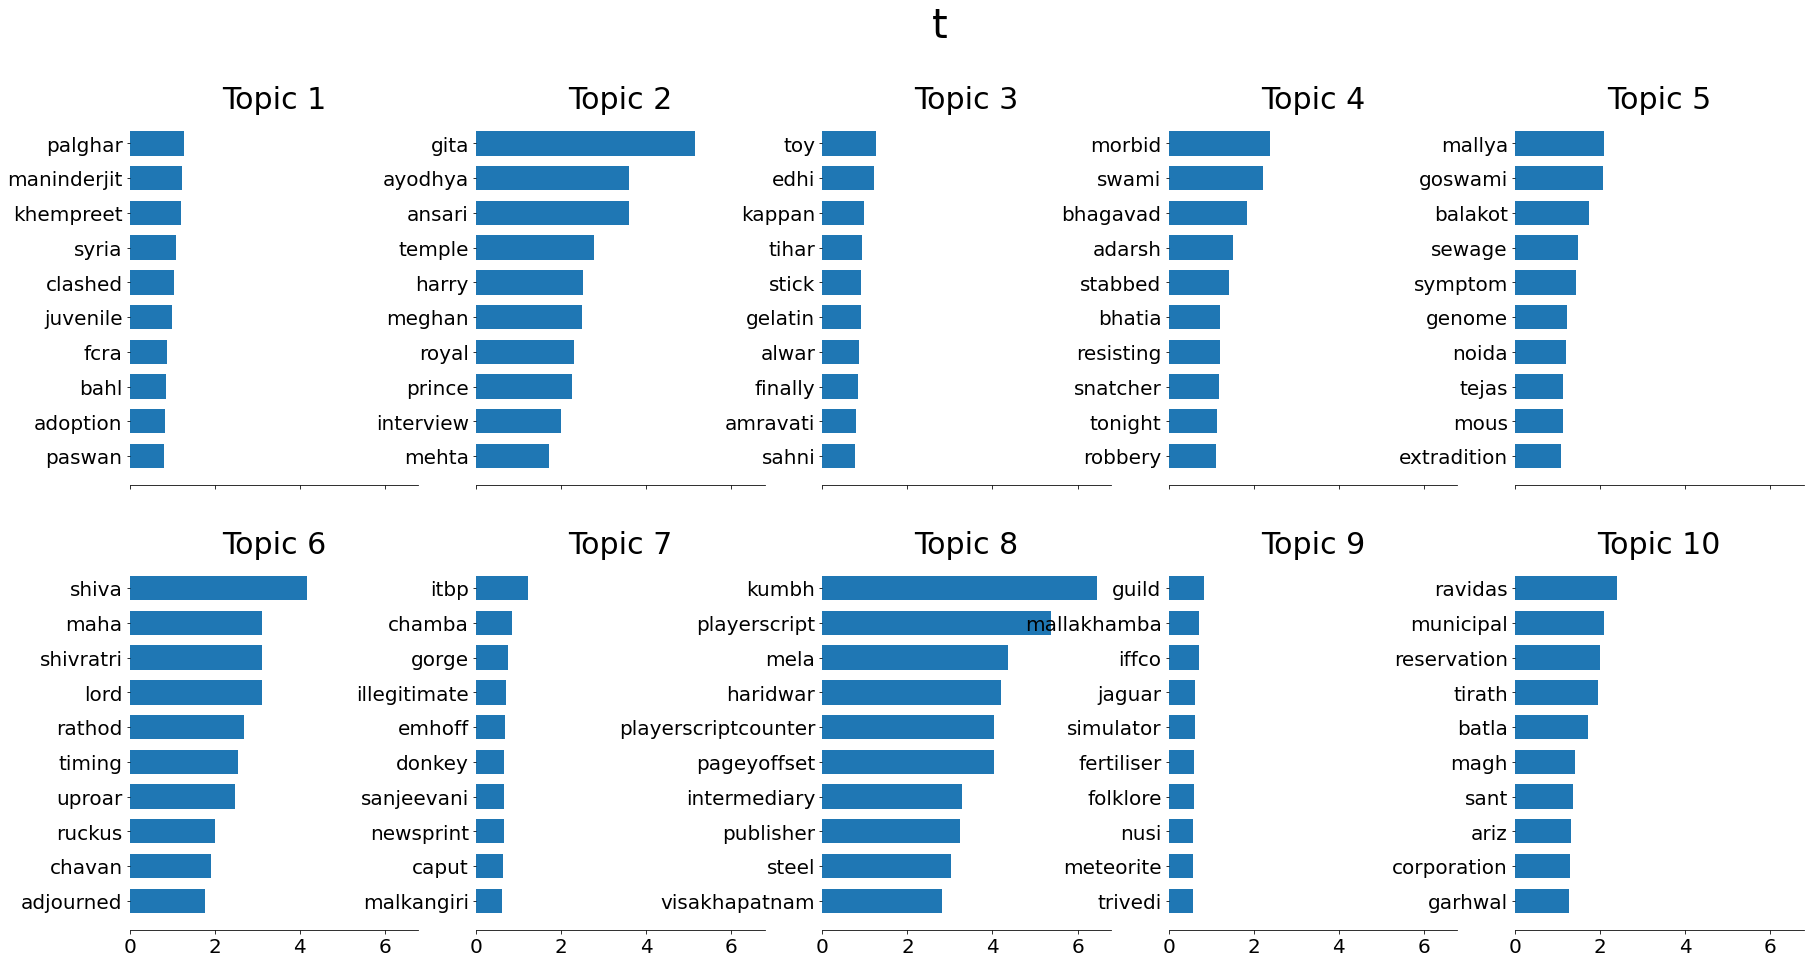

In [15]:
plot_top_words(lda, feature_names, 10, "t")

In [16]:
col = []
for i in range(lda_matrix.shape[1]):
    col.append("topic_{}".format(i)) 

topic_df_2 = pd.DataFrame(lda_matrix, columns = col)

topic_df_2["Docs"] = news_corpus.Content

l = ["Docs"]
for i in col:
    l.append(i)

display(topic_df_2[l])

,Docs,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,medium report about swedish manufacturer scani...,0.004586,0.004586,0.046754,0.004586,0.004586,0.004586,0.004586,0.004586,0.004586,0.004586,0.004586,0.004586,0.158676,0.004586,0.004586,0.056957,0.004586,0.004586,0.512381,0.004586,0.004586,0.133518,0.004586,0.004586,0.004586
1,access covid vaccine cooperation technology cl...,0.002871,0.002871,0.002871,0.002871,0.002871,0.055232,0.002871,0.010031,0.002871,0.002871,0.002871,0.002871,0.002871,0.002871,0.002871,0.081026,0.002871,0.070055,0.578338,0.006335,0.139339,0.010840,0.002871,0.002871,0.002871
2,after severe criticism over holding consultati...,0.004112,0.004112,0.004112,0.004112,0.004112,0.098434,0.004112,0.004112,0.004112,0.004112,0.004112,0.004112,0.004112,0.004112,0.004112,0.004112,0.004112,0.004112,0.714726,0.004112,0.004112,0.096368,0.004112,0.004112,0.004112
3,former congress president rahul gandhi thursda...,0.004178,0.004178,0.004178,0.004178,0.004178,0.004178,0.004178,0.004178,0.004178,0.004178,0.004178,0.130448,0.004178,0.004178,0.004178,0.109248,0.004178,0.004178,0.668397,0.004178,0.004178,0.004178,0.004178,0.004178,0.004178
4,enforcement directorate attached three immovab...,0.004818,0.004818,0.004818,0.004818,0.004818,0.004818,0.004818,0.004818,0.004818,0.004818,0.004818,0.004818,0.004818,0.004818,0.004818,0.041135,0.004818,0.017382,0.032391,0.004818,0.004818,0.807907,0.004818,0.004818,0.004818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4589,over mughal gold coin dating back early centur...,0.006132,0.006132,0.006132,0.006132,0.328174,0.006132,0.006132,0.006132,0.006132,0.006132,0.006132,0.006132,0.006132,0.006132,0.006132,0.006132,0.006132,0.006132,0.155745,0.006132,0.006132,0.381187,0.006132,0.006132,0.006132
4590,china planning spend tibet five year plan allo...,0.004949,0.004949,0.004949,0.004949,0.004949,0.004949,0.004949,0.004949,0.004949,0.004949,0.004949,0.004949,0.004949,0.004949,0.004949,0.004949,0.004949,0.004949,0.575845,0.004949,0.310337,0.004949,0.004949,0.004949,0.004949
4591,supreme court tuesday came with solution stale...,0.003091,0.003091,0.054484,0.003091,0.003091,0.003091,0.003091,0.003091,0.003091,0.003091,0.003091,0.105847,0.003091,0.003091,0.003091,0.092951,0.003091,0.003091,0.398085,0.003091,0.003091,0.286820,0.003091,0.003091,0.003091
4592,indian american maju varghese previously serve...,0.005681,0.005681,0.005681,0.005681,0.005681,0.005681,0.005681,0.005681,0.005681,0.005681,0.005681,0.005681,0.005681,0.034784,0.005681,0.078571,0.005681,0.253688,0.513651,0.005681,0.005681,0.005681,0.005681,0.005681,0.005681


# **Creating Users**

In [17]:
#fitting GMM to column "topic_i"

num_cols_topic_df = topic_df.shape[1]-1
gm = []

for i in range(num_cols_topic_df):
  gm.append(GaussianMixture(n_components=10).fit(topic_df.iloc[:, [i]]))


In [18]:
#generating gmm based topic values for each topic for 50 users
#24 x 50 matrix

Users = []

for i in range(50):
  temp = []
  for i in range(num_cols_topic_df):
    temp.append(gm[i].sample(1)[0][0][0])
  Users.append(temp)

Users = pd.DataFrame(Users)
Users.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.195346,0.374386,0.139097,0.093770,0.167718,0.124475,0.078694,0.174153,0.190687,0.132999,0.162284,0.119059,0.280590,0.213395,0.256917,0.106903,0.248947,0.177476,0.093274,0.227517,0.228950,0.115502,0.133702,0.131533,0.215102,0.240658,0.228202,0.156182,0.135906,0.180591,0.193837,0.196780,0.275124,0.216292,0.272029,0.192622,0.311537,0.165530,0.136020,0.090924,0.147313,0.124893,0.161996,0.245132,0.192791,0.079665,0.274210,0.335416,0.281844,0.234615
1,-0.137622,0.219788,-0.022482,0.159229,-0.027950,0.382690,-0.130311,-0.001450,-0.060152,-0.027299,-0.015853,-0.069240,-0.120807,0.417328,-0.062333,-0.037650,0.064842,-0.016009,-0.175167,-0.079829,-0.046516,-0.026052,-0.008497,-0.003130,-0.032701,-0.053769,-0.024036,0.319041,-0.010941,0.376227,0.091639,-0.010191,-0.023002,-0.040739,-0.052306,-0.023537,0.003310,-0.009426,0.009888,-0.043651,-0.039054,-0.044983,-0.001512,0.034826,-0.001639,-0.038179,-0.010973,0.311416,-0.035716,0.207119
2,0.062843,0.123444,0.038860,0.041253,-0.156458,-0.056104,0.264406,-0.095790,-0.131763,-0.197668,0.014971,-0.125186,0.218333,-0.098025,-0.120485,0.050999,-0.012878,-0.061743,0.286916,0.225284,0.007803,-0.026616,0.013798,0.236634,-0.134017,-0.000359,-0.127483,0.097528,0.020933,0.187045,-0.058078,-0.132560,-0.006867,0.002853,-0.033242,0.029811,-0.019180,0.082101,-0.052047,0.057743,0.009605,0.021692,0.024944,-0.036137,0.378427,0.003414,-0.249225,-0.019665,0.033327,-0.160417
3,-0.013962,-0.074816,-0.140529,0.013375,-0.055607,0.025575,0.009599,0.047080,0.015305,0.006492,0.026810,-0.021361,0.069938,0.021767,0.118614,0.010525,-0.016480,-0.024771,0.014861,0.362464,0.003616,-0.007372,0.060825,0.031761,0.011174,-0.024238,-0.105591,-0.007183,0.016258,0.363843,-0.105371,-0.038375,-0.031633,0.024727,0.015149,0.106933,0.012563,-0.014544,0.018580,-0.080324,0.018629,0.021692,-0.057771,-0.250586,-0.031958,-0.009136,0.050999,-0.011884,0.008579,-0.152237
4,0.039651,0.051436,0.084719,-0.025526,-0.037554,-0.066646,-0.019556,0.008782,-0.069808,-0.059855,-0.075123,-0.105482,-0.077711,0.001366,-0.010734,0.075646,0.016754,-0.044357,-0.029702,-0.101968,-0.159775,0.008294,0.068374,0.011808,-0.046460,-0.024232,-0.042046,-0.001176,-0.018171,-0.029926,0.008443,-0.110258,0.140222,-0.056988,0.032785,-0.019182,0.051762,-0.014485,0.150834,0.047747,-0.053544,-0.033297,0.030836,-0.187268,-0.077265,-0.036957,-0.178851,-0.041973,-0.066384,-0.159853
5,0.024444,-0.019310,0.062178,-0.019258,-0.008501,-0.033776,0.019851,-0.104087,-0.083755,-0.055097,0.090836,0.021757,-0.053913,-0.048906,0.087235,-0.045037,-0.077125,0.006211,-0.074898,-0.087496,-0.007612,0.024130,-0.087244,0.013636,-0.071544,-0.058845,-0.033933,0.012553,-0.121738,-0.028565,0.029996,-0.069059,-0.066412,-0.081371,0.250147,-0.023167,-0.083047,-0.062405,-0.012543,-0.043839,0.128998,-0.076771,-0.059566,0.274703,-0.088515,-0.084613,0.075323,-0.008120,-0.093428,-0.013115
6,0.137888,0.056870,0.047081,-0.081815,-0.028169,0.046802,-0.151231,-0.004127,-0.015029,0.001381,-0.030428,-0.116923,-0.022428,0.011912,-0.030354,0.074920,-0.063146,-0.063194,-0.011540,-0.101313,-0.095786,-0.002278,-0.097670,-0.033321,-0.016618,0.226553,-0.069719,-0.081956,0.051837,-0.010856,-0.078492,0.011617,-0.027417,-0.028497,0.050446,0.011346,-0.090068,-0.001091,0.018860,-0.064588,0.057545,-0.041317,-0.021747,-0.006724,0.188945,-0.166140,0.004849,-0.130289,-0.012881,-0.119981
7,-0.104723,0.016645,-0.055392,0.053565,0.057938,-0.012854,-0.019903,0.058346,0.027207,0.069598,0.020887,-0.010955,0.062532,0.029615,0.023255,-0.056157,-0.004184,0.079168,0.017397,-0.040281,-0.045923,-0.029067,-0.000500,0.044219,-0.019395,0.012469,-0.059984,0.155504,0.061619,0.020133,0.016520,0.069804,-0.070608,0.049358,0.014653,-0.243439,0.015043,-0.043209,-0.065604,0.364045,-0.066450,-0.118262,-0.020221,0.106414,-0.000563,0.020264,-0.001902,0.004357,0.088607,-0.015085
8,-0.057027,-0.040139,-0.015238,0.0

0.2403092284680765

Method 2 for Users

# **Cosine Similarity between Users and Docs**

In [19]:
#run the above cell before running this twice
slc = list(range(topic_df.shape[1]))
slc.remove(25)
temp_topic_df = topic_df.iloc[:, slc]
Users_temp = Users.T.set_index(temp_topic_df.T.index)

result = temp_topic_df.dot(Users_temp);
result.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4554,4555,4556,4557,4558,4559,4560,4561,4562,4563,4564,4565,4566,4567,4568,4569,4570,4571,4572,4573,4574,4575,4576,4577,4578,4579,4580,4581,4582,4583,4584,4585,4586,4587,4588,4589,4590,4591,4592,4593
0,0.022149,0.038523,0.020925,0.021391,0.030893,0.015191,0.072483,0.022963,0.054509,0.018565,0.028201,0.024477,0.028704,0.011489,0.023372,0.018461,0.032070,0.033618,0.008767,0.017298,0.054285,0.036049,0.050206,0.011762,0.016785,0.019904,0.011932,0.011263,0.031709,0.014761,0.013246,0.029273,0.075718,0.014882,0.043108,0.027370,0.038021,0.022928,0.020604,0.028889,...,0.007661,0.010240,0.021736,0.015409,0.018005,0.009629,0.007267,0.004271,0.007664,0.008087,0.015425,0.014259,0.008175,0.006988,0.002261,0.006791,0.013456,0.009261,0.011673,0.020312,0.020077,0.005537,0.006421,0.009083,0.010700,0.007558,0.015491,0.010434,0.012546,0.006447,0.011674,0.019679,0.023337,0.047268,0.052940,0.024527,0.024005,0.027659,0.009672,0.063062
1,0.033794,0.094355,0.067809,0.055862,0.026335,0.021877,0.144460,0.042991,0.068917,0.035061,0.044948,0.201525,0.065385,0.012706,0.040950,0.051306,0.063874,0.077210,0.053932,0.039650,0.084464,0.019511,0.043720,0.051671,0.049590,0.075265,0.058488,0.023766,0.082830,0.028388,0.026522,0.056503,0.069977,0.017810,0.063441,0.034914,0.074554,0.028961,0.033224,0.039340,...,0.015742,0.016697,0.026416,-0.036699,0.032869,0.013380,0.011119,0.006869,0.022325,0.013040,0.021024,0.018568,0.020752,0.016520,0.002841,0.021934,0.044198,0.027579,0.015486,0.031095,0.028750,0.036433,0.007502,0.015796,0.013075,0.013570,0.020736,0.023993,0.019947,0.026280,0.017837,0.020933,0.030949,0.056673,0.078021,0.026573,0.043937,0.031287,0.027237,0.074742
2,0.019428,-0.024267,0.032815,0.001526,0.031941,0.015510,0.087069,0.010972,0.050563,0.002584,0.014313,0.124407,0.038132,-0.001972,0.019170,-0.030534,0.006835,0.002363,0.020088,0.024492,0.036163,0.027373,0.062981,0.024243,0.009861,0.027894,0.017844,0.015035,0.054286,0.011220,0.019032,-0.005587,0.041525,0.021560,0.018957,0.030339,0.022559,0.001344,0.005723,0.035542,...,-0.003439,0.004447,0.008666,0.007472,-0.007845,0.000039,-0.000742,-0.001797,-0.010546,0.000932,0.007100,0.003537,-0.001926,-0.003298,-0.001309,0.011038,0.009991,0.001341,-0.005075,0.007842,0.013064,-0.012016,0.005678,0.002613,0.000896,-0.003939,0.007163,-0.008301,0.000932,-0.002708,0.002706,0.012806,0.010805,0.028931,0.033784,0.011746,0.005975,0.021344,-0.012892,0.054547
3,0.015837,0.030754,0.022803,0.022110,0.009996,0.003022,0.022193,0.005511,0.022800,0.024106,0.014842,0.089003,0.032884,-0.001910,0.005529,-0.015149,0.013120,-0.003085,0.021756,0.045907,0.014073,0.007811,0.007509,0.022697,0.026698,0.036095,0.030700,0.010590,0.019047,0.012980,0.009804,-0.006831,-0.008558,-0.004483,0.010264,-0.004022,0.008295,-0.009872,0.011191,0.006523,...,0.003518,0.007306,0.000083,-0.007626,0.015593,0.003464,0.000372,0.003033,0.006016,0.000853,0.008870,0.003368,0.003839,0.002727,0.000972,0.006053,0.017657,0.008910,0.014600,0.005073,0.011316,0.011085,0.001954,0.002498,0.002473,0.008572,0.002959,0.008157,0.001989,0.010197,0.002518,0.005085,0.010889,0.001080,0.004352,0.006013,0.013542,0.004435,0.013157,-0.008130
4,0.025804,0.024297,0.027579,0.026933,0.044538,0.053198,-0.006080,0.031850,0.031414,0.008036,0.032034,0.095346,0.019277,0.029017,0.013367,0.061128,0.027330,0.020986,0.028368,0.037453,0.063222,0.029320,0.041857,0.023265,0.046368,0.039490,0.013937,0.011635,0.040339,0.019397,0.073598,0.037522,0.066471,0.044682,0.021918,0.068334,0.020503,0.013678,0.036028,0.032774,...,0.008458,0.025386,0.006591,0.001847,0.018614,0.013277,0.004928,0.004618,0.012580,0.006998,0.017237,0.009362,0.007998,0.007089,0.001848,0.012758,0.013059,0.009689,0.013572,0.011971,0.016984,0.019171,0.003987,0.009106,0.009588,0.009973,0.008601,0.010538,0.007945,0.010160,0.006922,0.007739,0.021286,0.019312,0.020748,0.030441,0.022207,0.057222,0.018215,-0.000626
5,0.012763,0.036795,0.01

# **Find the best 10 documents for each user.**

In [20]:
selected_docs = result.T.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=10)
selected_docs.columns =['D1', 'D2', 'D3', 'D4', 'D5','D6','D7','D8','D9','D10']
selected_docs

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10
0,3568,2269,2295,1891,1862,1852,3935,3584,1702,2238
1,2454,2635,3910,3048,2115,465,2799,2618,2703,2684
2,2269,1852,2295,1767,1808,2195,1849,1891,1797,2368
3,1190,3091,1299,1121,3447,228,2559,1093,3207,3252
4,2221,2411,2128,2199,2124,2222,2169,2317,2219,2700
5,465,3910,2331,2920,3140,1121,3447,2559,3252,2110
6,3568,2658,3280,3339,3230,2554,2762,2652,2670,3501
7,3446,615,3283,704,2247,739,335,308,3323,3884
8,357,69,650,1823,3077,1348,3129,3121,320,3144
9,1213,2393,86,108,74,2404,90,2382,2386,2463


**Replacing index values by the actual news.**

In [21]:
doc_dict = news_corpus.Content.to_dict()

selected_docs = selected_docs.replace(doc_dict)
selected_docs

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10
0,delhi india february total assembly constituen...,dehradun uttarakhand india march shortly after...,dehradun uttarakhand india march predicting ch...,suspense loom over fate leadership uttarakhand...,just year ahead uttarakhand assembly election ...,uttarakhand chief minister trivendra singh raw...,delhi india february uttar pradesh kisan mazdo...,delhi india february election commission india...,agriculture state subject bhupinder singh hood...,dehradun uttarakhand india march bharatiya jan...
1,delhi india march india reported covid case re...,delhi india march union minister narendra sing...,delhi india february india reported case coron...,delhi india march many covid case death were r...,delhi india march india reported covid case re...,india third globally after highest cumulative ...,delhi india march many state union territory r...,amaravati andhra pradesh india march andhra pr...,delhi india march many covid case death were r...,bengaluru karnataka india march union minister...
2,dehradun uttarakhand india march shortly after...,uttarakhand chief minister trivendra singh raw...,dehradun uttarakhand india march predicting ch...,dhan singh rawat will likely chosen chief mini...,tirath singh rawat sabha from pauri uttarakhan...,dehradun uttarakhand india march tirath singh ...,trivendra singh rawat resigned chief minister ...,suspense loom over fate leadership uttarakhand...,bharatiya janata party tirath singh rawat took...,delhi india march amid speculation about leade...
3,tamil nadu puducherry punjab have registered l...,thiruvananthapuram kerala india march kerala r...,pregnant lactating woman have been part covid ...,total beneficiary were vaccinated till friday ...,mumbai maharashtra india february maharashtra ...,with several state country continuing report i...,delhi india march number covid case country sl...,india took only day administer million covid v...,mumbai maharashtra india march maharashtra rep...,delhi india march ministry health family welfa...
4,mumbai maharashtra india march national invest...,mumbai maharashtra india march national invest...,mumbai maharashtra india march maharashtra ant...,mumbai maharashtra india march maharashtra lea...,mumbai maharashtra india march maharashtra hom...,mumbai maharashtra india march bharatiya janat...,mumbai maharashtra india march maharashtra chi...,mumbai maharashtra india march leader oppositi...,mumbai maharashtra india march maharashtra hom...,mumbai maharashtra india march after owner exp...
5,india third globally after highest cumulative ...,delhi india february india reported case coron...,delhi india march nationwide covid vaccination...,delhi india march maharashtra kerala punjab ta...,delhi india march india total covid active cas...,total beneficiary were vaccinated till friday ...,mumbai maharashtra india february maharashtra ...,delhi india march number covid case country sl...,delhi india march ministry health family welfa...,delhi india march state including maharashtra ...
6,delhi india february total assembly constituen...,chennai tamil nadu india march india anna drav...,kanyakumari tamil nadu india march congress le...,tenkasi tamil nadu india february recalling fo...,kumar gauravnew delhi india march bhartiya jan...,chennai tamil nadu india march tamil nadu cong...,chennai tamil nadu india march with just month...,chennai tamil nadu india march ahead assembly ...,delhi india march meeting assam core group ove...,chennai tamil nadu india february union minist...
7,delhi india february around private hospital e...,urging centre make agri law prestige issue sen...,delhi india march second phase nationwide covi...,questioning ruling whether wanted permanent st...,delhi india march union home ministry tuesday ...,slamming centre over treatment farmer protesti...,warning that laxity implementing stringent mea...,union health ministry will soon issue format m...,delhi india february ahead commencement second...,de